In [51]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from operator import eq
import pandas as pd
import pandas_ta as ta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf

import datetime
from pathlib import Path

## IMPORT SKLEARN
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

import numpy as np
plt.style.use('seaborn')
from pprint import pprint

In [83]:
# IMPORT TENSORFLOW AND KERAS
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

df = pd.DataFrame()

In [52]:


def set_seeds(seed=2022): 
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)



In [53]:
equityData = pd.read_excel('StockDataCSV/EquityDataExcel.xlsx', sheet_name='Sheet1', index_col=0, usecols=[0,1], engine='openpyxl')
equityData.dropna(inplace=True)
equityData.drop(index=equityData.index[0], axis=0, inplace=True)
equityData.head()

,Adj Close
2017-07-31 00:00:00,2875.34
2017-08-01 00:00:00,2718.26
2017-08-02 00:00:00,2710.67
2017-08-03 00:00:00,2804.73
2017-08-04 00:00:00,2895.89


In [54]:
### Path to store results

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [70]:
data = equityData['Adj Close']

data = data.to_numpy()
data = np.reshape(data, (-1, 1))
data.shape

(1826, 1)

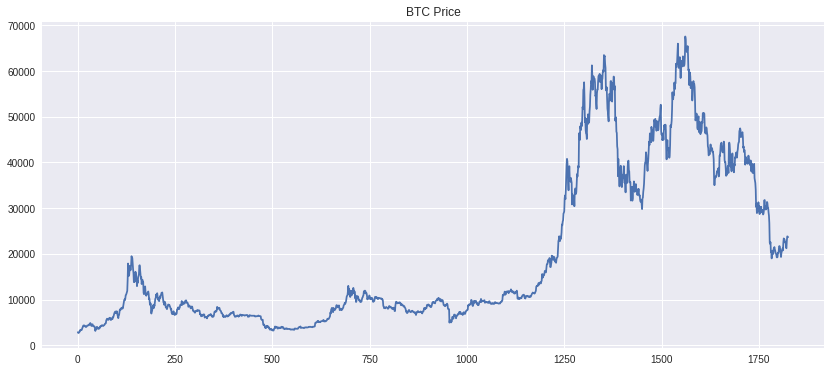

In [71]:
# Visualization 
plt.figure(figsize=(14,6))
plt.title('BTC Price')
plt.plot(data);

In [72]:
#### TRAIN - TEST SPLIT
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 1460, 366


In [73]:
#### PREPROCESSING
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [74]:
#### GENERATE SEQUENCE

def generate_sequence(data, sequence_length=60):
    
    # create X & y data array
    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
    
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [75]:
# sequence length
lookback = 60

In [76]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (1400, 60), y_train (1400,)


In [77]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (306, 60), y_test (306,)


In [78]:
#### RESHAPE

# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis] 

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (1400, 60, 1), y_train (1400, 1)


In [79]:
# reshaping test array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

# check the test array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (306, 60, 1), y_test (306, 1)


In [81]:
#### CREATE THE MODEL
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()   
    
    # instantiate the model
    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, 1), activation = 'relu', return_sequences=False, name='LSTM'))
    model.add(Dense(units=1, name='Output'))              # can also specify linear activation function 
    
    # specify optimizer separately (preferred method))
#     opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       # adam optimizer seems to perform better for a single lstm
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [84]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [85]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [89]:
#### TRAIN THE MODEL
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]

In [102]:
# Model fitting
lstm_training = model.fit(X_train, 
                          y_train, 
                          batch_size=64, 
                          epochs=500, 
                          verbose=1, 
                          callbacks=my_callbacks, 
                          shuffle=False)

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 5.8510e-04 - mae: 0.0139
Epoch 1: loss improved from 0.00063 to 0.00063, saving model to results/lstm_time_series/model.h5
22/22 [==============================] - 1s 43ms/step - loss: 6.2763e-04 - mae: 0.0147
Epoch 2/500
21/22 [===========================>..] - ETA: 0s - loss: 5.7883e-04 - mae: 0.0139
Epoch 2: loss improved from 0.00063 to 0.00062, saving model to results/lstm_time_series/model.h5
22/22 [==============================] - 1s 40ms/step - loss: 6.2171e-04 - mae: 0.0146
Epoch 3/500
22/22 [==============================] - ETA: 0s - loss: 6.1494e-04 - mae: 0.0146
Epoch 3: loss improved from 0.00062 to 0.00061, saving model to results/lstm_time_series/model.h5
22/22 [==============================] - 1s 43ms/step - loss: 6.1494e-04 - mae: 0.0146
Epoch 4/500
22/22 [==============================] - ETA: 0s - loss: 6.0842e-04 - mae: 0.0145
Epoch 4: loss improved from 0.00061 to 0.00061, saving model to resul

Epoch 33/500
21/22 [===========================>..] - ETA: 0s - loss: 4.1851e-04 - mae: 0.0119
Epoch 33: loss did not improve from 0.00045
22/22 [==============================] - 1s 51ms/step - loss: 4.6002e-04 - mae: 0.0127
Epoch 34/500
21/22 [===========================>..] - ETA: 0s - loss: 4.0923e-04 - mae: 0.0113
Epoch 34: loss improved from 0.00045 to 0.00045, saving model to results/lstm_time_series/model.h5
22/22 [==============================] - 1s 49ms/step - loss: 4.4865e-04 - mae: 0.0121
Epoch 35/500
21/22 [===========================>..] - ETA: 0s - loss: 4.1109e-04 - mae: 0.0117
Epoch 35: loss did not improve from 0.00045
22/22 [==============================] - 1s 41ms/step - loss: 4.5248e-04 - mae: 0.0125
Epoch 36/500
21/22 [===========================>..] - ETA: 0s - loss: 4.0336e-04 - mae: 0.0112
Epoch 36: loss improved from 0.00045 to 0.00044, saving model to results/lstm_time_series/model.h5
22/22 [==============================] - 1s 41ms/step - loss: 4.4248e-04 

In [114]:
%tensorboard --logdir logs

In [105]:
#### ERROR CALC


# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0219 | Test RMSE: 0.0373


In [106]:
# predictions
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 15ms/step


In [112]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()})

df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
0,41034.542969,42643.253906,1608.710938
1,41564.363281,42260.652344,696.289063
2,43790.894531,41950.363281,-1840.531250
3,48116.941406,42170.683594,-5946.257812
4,47711.488281,43434.695312,-4276.792969
...,...,...,...
301,21239.753906,23895.601562,2655.847656
302,22930.548828,23581.921875,651.373047
303,23843.886719,23575.355469,-268.531250
304,23804.632812,23826.660156,22.027344


In [108]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.9675


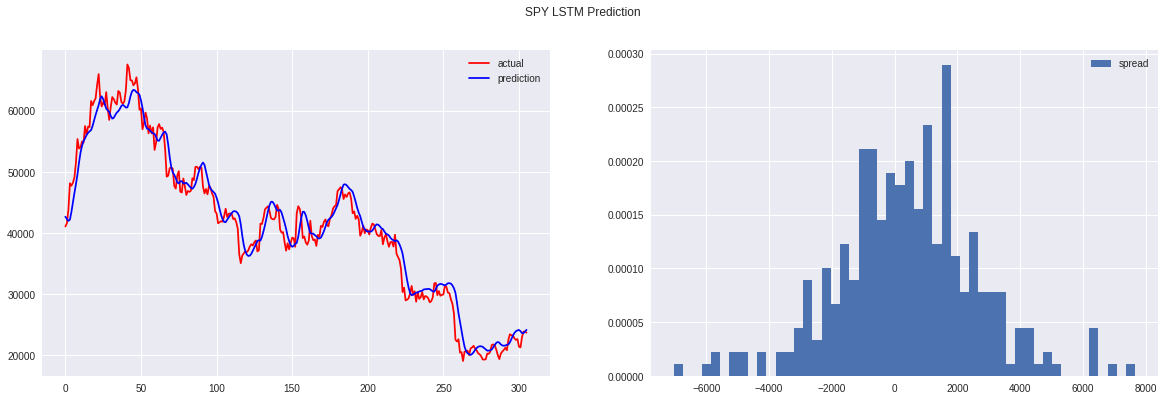

In [109]:
#### PLOT RESULTS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');

In [116]:
X_test.shape

(306, 60, 1)

In [117]:
X_test

array([[[0.65015734],
        [0.64013392],
        [0.61297115],
        ...,
        [0.65807024],
        [0.6661624 ],
        [0.65016036]],

       [[0.64013392],
        [0.61297115],
        [0.60025666],
        ...,
        [0.6661624 ],
        [0.65016036],
        [0.63040165]],

       [[0.61297115],
        [0.60025666],
        [0.5830019 ],
        ...,
        [0.65016036],
        [0.63040165],
        [0.63911683]],

       ...,

       [[0.43977729],
        [0.47728887],
        [0.47837321],
        ...,
        [0.30679678],
        [0.30479083],
        [0.33260326]],

       [[0.47728887],
        [0.47837321],
        [0.44558592],
        ...,
        [0.30479083],
        [0.33260326],
        [0.34762704]],

       [[0.47837321],
        [0.44558592],
        [0.45658078],
        ...,
        [0.33260326],
        [0.34762704],
        [0.34698134]]])